# Emulate the RFMIP forcing from other SSPs

Forcing from SSPs is provided from a combination of

- greenhouse gases
- aerosols
- solar & volcanic (combined "natural")
- other anthropogenic
  - land use change
  - ozone
  
We wish to use the SSP2-4.5 model-specific ERFs from RFMIP and apply them to other scenarios. Do as follows:
- Greenhouse gases: isolate CO2 from other GHGs based on 4xCO2 and 2014 GHG ERFs. For other GHGs, scale the contribution of each according to Etminan/Meinshauen formulas.
- Aerosols: use emissions-based emulator developed in Smith et al. (2021)
- Solar and volcanic: can use RFMIP transient scenarios without modification
- Other anthropogenic:
  - land use change: use 2014 Tier 1 values, scale the time series to cumulative CO2 emissions 
  - ozone: residual of total - natural - aerosol - ghg - landuse

In [1]:
import errno
import json
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd

In [2]:
scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
emitted_species = ['BC', 'OC', 'Sulfur']
emissions = {}

In [3]:
def check_and_download(filepath, url):
    """Checks prescence of a file and downloads if not present.

    Inputs
    ------
        filepath : str
            filename to download to
        url :
            url to download from
    """
    if not os.path.isfile(filepath):
        urllib.request.urlretrieve(url, filepath)
    return

In [4]:
check_and_download('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv', 'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv')

## Aerosols will be easiest

In [5]:
emissions_df = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')

In [6]:
for scenario in scenarios:
    emissions[scenario] = {}
    for specie in emitted_species:
        emissions[scenario][specie] = emissions_df.loc[
            (emissions_df['Scenario']==scenario) & 
            (emissions_df['Variable']=='Emissions|{}'.format(specie)) &
            (emissions_df['Region']=='World'), 
            '1750':'2100'
        ].interpolate(axis=1).values.squeeze()

In [7]:
with open('../data_output/cmip6_aerosol_coefficients.json') as f:
    aerosol_tunings = json.load(f)

In [8]:
models = [key for key in aerosol_tunings.keys() if key != 'mean']

In [9]:
models

['CanESM5',
 'CNRM-CM6-1',
 'E3SM',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'UKESM1-0-LL']

In [10]:
aerosol_tunings[models[0]]['ERFari']['BC']

0.03259343948789619

In [11]:
erf = {}
for model in models:
    erf[model] = {}
    for scenario in scenarios:
        erf[model][scenario] = {}

In [12]:
def aerocom(x, bc, oc, so2):
    return bc*x[0] + oc*x[1] + so2*x[2]

def ghan(x, beta, n0, n1):
    return -beta*np.log(1 + x[0]/n0 + x[1]/n1)

In [13]:
for model in models:
    for scenario in scenarios:
        x_ari = np.array([emissions[scenario]['BC'], emissions[scenario]['OC'], emissions[scenario]['Sulfur']])
        x_aci = np.array([emissions[scenario]['Sulfur'], emissions[scenario]['BC']+emissions[scenario]['OC']])
        erf[model][scenario]['aerosol'] = (
            aerocom(
                x_ari,
                aerosol_tunings[model]['ERFari']['BC'],
                aerosol_tunings[model]['ERFari']['OC'],
                aerosol_tunings[model]['ERFari']['SO2'],
            ) - aerocom(
                x_ari[:, 100],
                aerosol_tunings[model]['ERFari']['BC'],
                aerosol_tunings[model]['ERFari']['OC'],
                aerosol_tunings[model]['ERFari']['SO2'],
            )
        ) + (
            ghan(
                x_aci,
                aerosol_tunings[model]['ERFaci']['beta'],
                aerosol_tunings[model]['ERFaci']['n0'],
                aerosol_tunings[model]['ERFaci']['n1'],
            ) - ghan(
                x_aci[:, 100],
                aerosol_tunings[model]['ERFaci']['beta'],
                aerosol_tunings[model]['ERFaci']['n0'],
                aerosol_tunings[model]['ERFaci']['n1'],
            )
        )

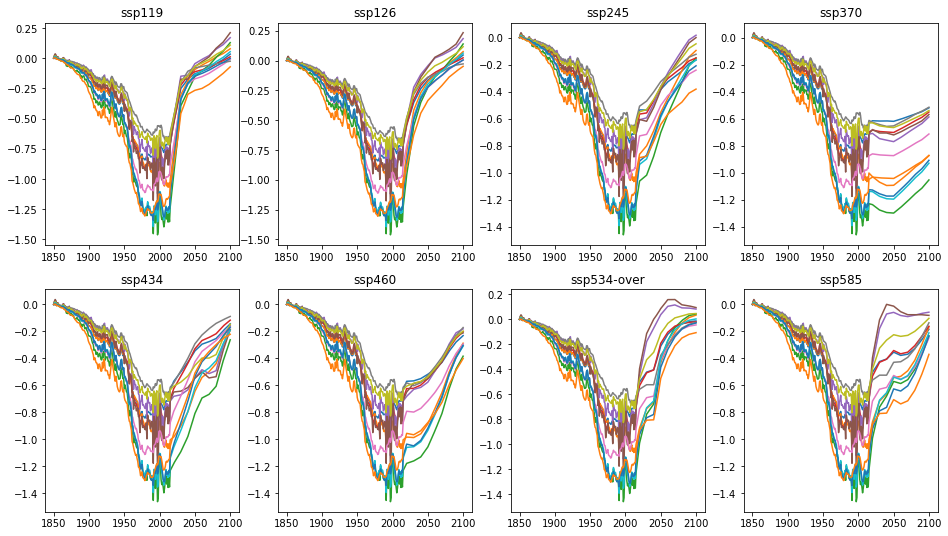

In [15]:
fig, ax = pl.subplots(2, 4, figsize=(16,9))

for iscen, scenario in enumerate(scenarios):
    for model in models:
        ax[iscen//4, iscen%4].plot(np.arange(1850, 2101), erf[model][scenario]['aerosol'][100:])
        ax[iscen//4, iscen%4].set_title(scenario)